<a href="https://colab.research.google.com/github/anubhavgupta1/DeepLearning/blob/master/13_Deep_CNN_Torch_Vision_Models_Zoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline

1. Loading datasets - Transforming images
2. VGG-16 with modification to network head
3. Using pre-trained models
4. Storing intermediate models
5. Resnet
6. Inception v3

In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
#Transfer Learning
# Using a model that is pre-trained on large comprehensive datasets and transferring that learning by modifying it slightly to perform the task at hand.

## Dataset, transforms, and visualisation

In [0]:
#Z-score normalization
#z_i = (x_i - x_mean)/x_std_deviation now z_i will lie between ( 0 and 1 ) 
#The main difference comes after normalizing the values as it reduces the skewness in our data, 
#it's just hypothetical that at mean=0.5 and std=0.5, CNNs tend to train better.

In [0]:

#sequence of operations in a pipeline

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  #CIFAR10 32 x 32 ==> 224 X 224 { VGG16, ResNet 224 x 224 }
    transforms.ToTensor(), #conversion into tensor 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #Z-score normalization
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [6]:
#download of CIFAR 10 IMAGES

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

0it [00:00, ?it/s]

170500096it [00:04, 38636904.80it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
#CIFAR10 has 10 classes
num_classes = 10

In [0]:
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [10]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
9


In [11]:
# by default min - max scaling is already performed on pixels  
print(images[1][0, :, :].shape)
print(images[1][0, :, :])

torch.Size([224, 224])
tensor([[ 0.7255,  0.7255,  0.7255,  ...,  0.6392,  0.6392,  0.6392],
        [ 0.7255,  0.7255,  0.7255,  ...,  0.6392,  0.6392,  0.6392],
        [ 0.7255,  0.7255,  0.7255,  ...,  0.6392,  0.6392,  0.6392],
        ...,
        [ 0.2157,  0.2157,  0.2157,  ..., -0.8196, -0.8196, -0.8196],
        [ 0.2157,  0.2157,  0.2157,  ..., -0.8196, -0.8196, -0.8196],
        [ 0.2157,  0.2157,  0.2157,  ..., -0.8196, -0.8196, -0.8196]])


In [12]:
x_i = images[1][0, :, :]
z_i = ((x_i-0.5)/0.5)
print(z_i)

tensor([[ 0.4510,  0.4510,  0.4510,  ...,  0.2784,  0.2784,  0.2784],
        [ 0.4510,  0.4510,  0.4510,  ...,  0.2784,  0.2784,  0.2784],
        [ 0.4510,  0.4510,  0.4510,  ...,  0.2784,  0.2784,  0.2784],
        ...,
        [-0.5686, -0.5686, -0.5686,  ..., -2.6392, -2.6392, -2.6392],
        [-0.5686, -0.5686, -0.5686,  ..., -2.6392, -2.6392, -2.6392],
        [-0.5686, -0.5686, -0.5686,  ..., -2.6392, -2.6392, -2.6392]])


In [0]:
#How would you de-normalize an image after it undergoes transforms.Normalize((0.3, 0.3, 0.3), (0.4, 0.4, 0.4))
#npimg = img.numpy() / 2.5 + 0.3


In [0]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5 #un-normalize image pixels
    plt.figure(figsize=(batch_size, 4))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # 3, 224, 224 ===> 224, 224, 3
    plt.title(title)
    plt.show()

In [0]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

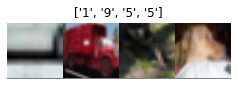

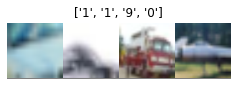

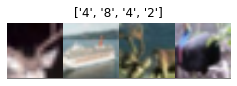

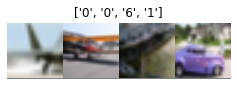

In [15]:
for i in range(4):
    show_batch_images(trainloader)

## Creating VGG-16

https://pytorch.org/docs/master/torchvision/models.html#torchvision-models

https://pytorch.org/docs/master/_modules/torchvision/models/vgg.html


In [0]:
from torchvision import models

In [0]:
vgg = models.vgg16_bn() # bn stands for batch normalisation

In [18]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [19]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [20]:
#key part
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [0]:
# output_featurs = 1000 because VggNet is trained on ImageNet but CIFAR10 out_feature = 10 is required. So we delete layer of 1000 neurons instead we placed layer of 10 neurons

In [0]:
#It is possible to change the number of output features of a layer in torchvision.model.vgg16 by 
#simply replacing that particular layer with a new nn.Linear() or nn.Conv2d() layer of our choice.

In [23]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [24]:
# now we need to change vgg classifier features will be same only classifier wqill change 
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Train CIFAR10

In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.33
Iteration: 100/3125, Loss: 2.72
Iteration: 200/3125, Loss: 3.36
Iteration: 300/3125, Loss: 2.48
Iteration: 400/3125, Loss: 2.22
Iteration: 500/3125, Loss: 2.29
Iteration: 600/3125, Loss: 2.20
Iteration: 700/3125, Loss: 2.38
Iteration: 800/3125, Loss: 2.63
Iteration: 900/3125, Loss: 2.41
Iteration: 1000/3125, Loss: 2.44
Iteration: 1100/3125, Loss: 2.30
Iteration: 1200/3125, Loss: 2.25
Iteration: 1300/3125, Loss: 2.30
Iteration: 1400/3125, Loss: 2.07
Iteration: 1500/3125, Loss: 2.15
Iteration: 1600/3125, Loss: 2.19
Iteration: 1700/3125, Loss: 2.49
Iteration: 1800/3125, Loss: 2.24
Iteration: 1900/3125, Loss: 2.26
Iteration: 2000/3125, Loss: 2.00
Iteration: 2100/3125, Loss: 2.63
Iteration: 2200/3125, Loss: 1.76
Iteration: 2300/3125, Loss: 2.14
Iteration: 2400/3125, Loss: 1.79
Iteration: 2500/3125, Loss: 2.46
Iteration: 2600/3125, Loss: 2.01
Iteration: 2700/3125, Loss: 2.11
Iteration: 2800/3125, Loss: 2.14
Iteration: 2900/3125, Loss: 2.02
Iteration: 3000/3125, 

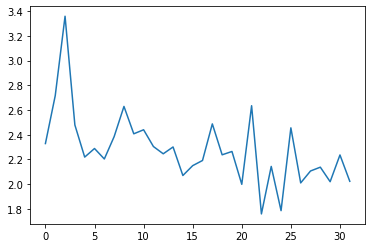

CPU times: user 9min 33s, sys: 7min 4s, total: 16min 37s
Wall time: 16min 39s


In [28]:
%%time
loss_epoch_arr = []
max_epoch = 1



n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epoch):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            loss_epoch_arr.append(loss.item())
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    #loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epoch, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [0]:
# loss(random) = 2.3 approx

In [0]:
# It is taking very long time to train. So we need to speed up.
# Adding momentum to optim.SGD()
# selecting a different optimizer like optim.ADAM()

### Freeze layers of Convolutional Operations

In [0]:
# Rather than doing things from  scratch, we can use pre - trained models which are already trained on some network and their most optimized wights have been saved.
# Then we can use those weights and can train only parts of our network.

In [0]:
#What benefits does transfer learning offer over training the entire model maually?
# The pre trained model is trained on very large volumes of data, which might be difficult to replicate during manual training with our own dataset. 
# The number of parameters to be trained is drastically reduced, as far we only train few layersto fine tune the output model.

In [0]:

batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [34]:
vgg = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:08<00:00, 67.6MB/s]


In [0]:
# if we do back propagation we don't need to update parameters ie weights or bias because they are already in their stage.
# these parameters are frozen parameters
for param in vgg.parameters():
    param.requires_grad = False

In [0]:
# we delete layer of 1000 neurons instead we placed layer of 10 neurons. So we need to train only these parameters out of 13 million parameters
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [37]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [38]:
# total parameters in the network
for param in vgg.parameters():
  print(param.shape)

torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512,

In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.42
Iteration: 100/3125, Loss: 1.49
Iteration: 200/3125, Loss: 2.37
Iteration: 300/3125, Loss: 1.32
Iteration: 400/3125, Loss: 2.15
Iteration: 500/3125, Loss: 1.59
Iteration: 600/3125, Loss: 1.49
Iteration: 700/3125, Loss: 2.47
Iteration: 800/3125, Loss: 1.71
Iteration: 900/3125, Loss: 2.13
Iteration: 1000/3125, Loss: 2.42
Iteration: 1100/3125, Loss: 2.17
Iteration: 1200/3125, Loss: 1.81
Iteration: 1300/3125, Loss: 3.03
Iteration: 1400/3125, Loss: 0.99
Iteration: 1500/3125, Loss: 2.30
Iteration: 1600/3125, Loss: 2.92
Iteration: 1700/3125, Loss: 1.93
Iteration: 1800/3125, Loss: 1.44
Iteration: 1900/3125, Loss: 1.52
Iteration: 2000/3125, Loss: 1.91
Iteration: 2100/3125, Loss: 1.97
Iteration: 2200/3125, Loss: 1.99
Iteration: 2300/3125, Loss: 3.93
Iteration: 2400/3125, Loss: 2.21
Iteration: 2500/3125, Loss: 1.50
Iteration: 2600/3125, Loss: 2.65
Iteration: 2700/3125, Loss: 1.97
Iteration: 2800/3125, Loss: 1.01
Iteration: 2900/3125, Loss: 2.00
Iteration: 3000/3125, 

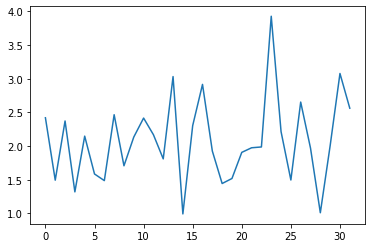

CPU times: user 6min 18s, sys: 2min 58s, total: 9min 16s
Wall time: 9min 17s


In [40]:
%%time
loss_epoch_arr = []
max_epoch = 1



n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epoch):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            loss_epoch_arr.append(loss.item())
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    #loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epoch, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [0]:
# instability of loss; we should stable loss; Checkpinting

### With model copies

In [0]:
# Checkpointing
# store all the parameters of the network when we achieve signigicance improvement in loss 

In [0]:
import copy
# it allows us to make copies of the structures in python

In [44]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())#vgg.state_dict() gives access to entire parameter state.
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

Min loss 3.07
Iteration: 0/3125, Loss: 3.07
Min loss 1.47
Min loss 1.03
Min loss 0.96
Min loss 0.88
Iteration: 100/3125, Loss: 2.74
Min loss 0.77
Iteration: 200/3125, Loss: 1.19
Min loss 0.69
Iteration: 300/3125, Loss: 1.19
Iteration: 400/3125, Loss: 1.33
Min loss 0.61
Iteration: 500/3125, Loss: 0.84
Iteration: 600/3125, Loss: 1.63
Iteration: 700/3125, Loss: 3.40
Iteration: 800/3125, Loss: 2.72
Iteration: 900/3125, Loss: 2.26
Iteration: 1000/3125, Loss: 2.24
Iteration: 1100/3125, Loss: 1.57
Iteration: 1200/3125, Loss: 2.13
Iteration: 1300/3125, Loss: 1.45
Min loss 0.59
Iteration: 1400/3125, Loss: 2.09
Iteration: 1500/3125, Loss: 1.90
Iteration: 1600/3125, Loss: 1.64
Iteration: 1700/3125, Loss: 1.66
Iteration: 1800/3125, Loss: 2.41
Iteration: 1900/3125, Loss: 1.99
Iteration: 2000/3125, Loss: 2.17
Iteration: 2100/3125, Loss: 2.34
Iteration: 2200/3125, Loss: 2.00
Iteration: 2300/3125, Loss: 2.56
Iteration: 2400/3125, Loss: 2.12
Iteration: 2500/3125, Loss: 2.98
Min loss 0.56
Iteration: 260

In [45]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

45.546 44.71


## ResNet Model

https://pytorch.org/docs/master/_modules/torchvision/models/resnet.html

In [46]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 19.3MB/s]


In [47]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in resnet.parameters():
    param.requires_grad = False

In [0]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [50]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [0]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)

Min loss 2.57
Iteration: 0/3125, Loss: 2.57
Min loss 2.55
Min loss 2.37
Min loss 2.36
Min loss 2.26
Min loss 2.23
Min loss 2.01
Min loss 1.98
Min loss 1.93
Min loss 1.80
Min loss 1.76
Min loss 1.75
Min loss 1.74
Min loss 1.64
Min loss 1.50
Min loss 1.44
Iteration: 100/3125, Loss: 1.87
Min loss 1.33
Iteration: 200/3125, Loss: 1.35
Min loss 1.30
Min loss 1.21
Min loss 1.19
Min loss 1.15
Iteration: 300/3125, Loss: 1.45
Min loss 1.07
Iteration: 400/3125, Loss: 1.53
Min loss 1.03
Iteration: 500/3125, Loss: 2.05
Min loss 0.93
Min loss 0.89
Iteration: 600/3125, Loss: 1.32
Min loss 0.88
Iteration: 700/3125, Loss: 1.55
Iteration: 800/3125, Loss: 1.33
Min loss 0.87
Iteration: 900/3125, Loss: 1.59
Min loss 0.84
Min loss 0.72
Iteration: 1000/3125, Loss: 1.15
Min loss 0.65
Iteration: 1100/3125, Loss: 1.33
Iteration: 1200/3125, Loss: 1.06
Iteration: 1300/3125, Loss: 1.35
Iteration: 1400/3125, Loss: 1.27
Iteration: 1500/3125, Loss: 1.39
Min loss 0.64
Min loss 0.62
Iteration: 1600/3125, Loss: 1.23
Min

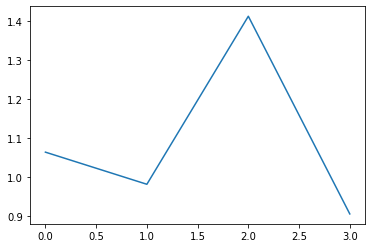

In [52]:
loss_epoch_arr = []
max_epochs = 4

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [43]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

56.414 56.01


## Inception Model

https://pytorch.org/docs/master/_modules/torchvision/models/inception.html

In [0]:
#5 different types of Inception modules are implemented in torchvision.models.inception_v3()

In [53]:
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
100%|██████████| 104M/104M [00:01<00:00, 55.0MB/s] 


In [54]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [0]:
for param in inception.parameters():
    param.requires_grad = False

In [0]:
#Now we need to change number of output classes noy only in final output but in auxilliary output also 

In [0]:
#change in auxilliary output
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [63]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [0]:
# auxilliary parameters = 7690

In [0]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [65]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [0]:
# FC parameters = 20490
#total parameters need to train = 7690+ 20490 = 28180 

In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [68]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr=0.01)

In [0]:
#Here we need to update evaluation function slightly,
# if we want to evaluate the auxilliary output.
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 2.84
Iteration: 0/3125, Loss: 2.84
Min loss 2.68
Min loss 2.67
Min loss 2.57
Min loss 2.50
Min loss 2.50
Min loss 2.44
Min loss 2.37
Min loss 2.31
Min loss 2.29
Iteration: 100/3125, Loss: 2.51
Min loss 2.27
Min loss 2.21
Min loss 2.13
Min loss 2.11
Min loss 2.07
Min loss 2.06
Iteration: 200/3125, Loss: 2.31
Min loss 2.05
Min loss 1.86
Min loss 1.70
Iteration: 300/3125, Loss: 2.62
Iteration: 400/3125, Loss: 2.25
Iteration: 500/3125, Loss: 1.73
Min loss 1.60
Iteration: 600/3125, Loss: 2.32
Min loss 1.55
Iteration: 700/3125, Loss: 2.56
Min loss 1.34
Iteration: 800/3125, Loss: 2.26
Iteration: 900/3125, Loss: 2.56
Iteration: 1000/3125, Loss: 1.85
Iteration: 1100/3125, Loss: 2.15
Iteration: 1200/3125, Loss: 2.45
Min loss 1.17
Iteration: 1300/3125, Loss: 2.24
Iteration: 1400/3125, Loss: 2.10
Iteration: 1500/3125, Loss: 2.01
Iteration: 1600/3125, Loss: 1.96
Min loss 1.12
Iteration: 1700/3125, Loss: 1.95
Min loss 1.12
Iteration: 1800/3125, Loss: 2.23
Iteration: 1900/3125, Loss: 1.92
It

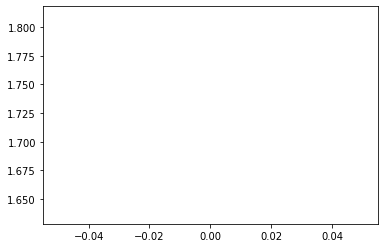

In [73]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [57]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

46.244 46.62
